In [29]:

import numpy as np
from torch import nn
from PIL import Image, ImageOps
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
# from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.image as mpimg
from torch.utils.data import Dataset
import os
import torch.optim as optim
# from keras.applications.vgg16 import VGG16
import kagglehub
import IPython
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm


In [30]:
class FolderDataset(Dataset):
    """
    Creates a PyTorch dataset from folder, returning two tensor images.
    Args: 
    main_dir : directory where images are stored.
    transform (optional) : torchvision transforms to be applied while making dataset
    """

    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])



        image = Image.open(img_loc).convert("RGB")
        image = image.resize((256, 256))
        image.save(img_loc)


        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [31]:
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        return x

In [32]:
class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)
        return x

In [33]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    train_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    optimizer: PyTorch optimizer.
    device: "cuda" or "cpu"
    Returns: Train Loss
    """
    #  Set networks to train mode.
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        # Move images to device
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Zero grad the optimizer
        optimizer.zero_grad()
        # Feed the train images to encoder
        enc_output = encoder(train_img)
        # The output of encoder is input to decoder !
        dec_output = decoder(enc_output)
        
        # Decoder output is reconstructed image
        # Compute loss with it and orginal image which is target image.
        loss = loss_fn(dec_output, target_img)
        # Backpropogate
        loss.backward()
        # Apply the optimizer to network by calling step.
        optimizer.step()
    # Return the loss
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    val_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    device: "cuda" or "cpu"
    Returns: Validation Loss
    """
    
    # Set to eval mode.
    encoder.eval()
    decoder.eval()
    
    # We don't need to compute gradients while validating.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            # Move to device
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # Again as train. Feed encoder the train image.
            enc_output = encoder(train_img)
            # Decoder takes encoder output and reconstructs the image.
            dec_output = decoder(enc_output)

            # Validation loss for encoder and decoder.
            loss = loss_fn(dec_output, target_img)
    # Return the loss
    return loss.item()

In [34]:
def create_embedding(encoder, full_loader, device):
    """
    Creates embedding using the encoder from a dataloader.
    Args:
      encoder: A convolutional Encoder.
      full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
      device: "cuda" or "cpu"
    Returns:
      Embedding tensor containing the outputs of the encoder for the full dataset.
    """
    encoder.eval()
    embeddings = []  # List to store outputs from each batch
    
    with torch.no_grad():
        for batch_idx, (train_img, _) in enumerate(full_loader):
            train_img = train_img.to(device)
            # Get encoder outputs and move to CPU
            enc_output = encoder(train_img).cpu()
            embeddings.append(enc_output)
    
    embedding = torch.cat(embeddings, dim=0)

    return embedding


In [35]:
import torch
import torchvision.transforms as T

transforms = T.Compose([T.ToTensor()]) # Normalize the pixels and convert to tensor.

full_dataset = FolderDataset("Photos-001", transforms) # Create folder dataset.

train_size = 0.75
val_size = 1 - train_size

# Split data to train and test
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size]) 

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
 
# Create the validation dataloader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Create the full dataloader
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

loss_fn = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = ConvEncoder() # Our encoder model
decoder = ConvDecoder() # Our decoder model

device = "cpu"  # GPU device

# Shift models to GPU
encoder.to(device)
decoder.to(device)

max_loss = 0.1

# Both the enocder and decoder parameters
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-3) # Adam Optimizer

# Time to Train !!!
EPOCHS = 10
# Usual Training Loop
for epoch in tqdm(range(EPOCHS)):
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
        
        print(f"Epochs = {epoch}, Training Loss : {train_loss}")
        
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        
        print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

        # Simple Best Model saving
        if val_loss < max_loss:
            print("Validation Loss decreased, saving new best model")
            torch.save(encoder.state_dict(), "encoder_model.pt")
            torch.save(decoder.state_dict(), "decoder_model.pt")

# Save the feature representations.
EMBEDDING_SHAPE = (1, 256, 16, 16) # This we know from our encoder

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_loader, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs = 0, Training Loss : 0.11017321795225143


 10%|█         | 1/10 [00:59<08:55, 59.48s/it]

Epochs = 0, Validation Loss : 0.24379600584506989
Epochs = 1, Training Loss : 0.08782216906547546


 20%|██        | 2/10 [01:06<03:46, 28.35s/it]

Epochs = 1, Validation Loss : 0.2080363631248474
Epochs = 2, Training Loss : 0.09596604108810425


 30%|███       | 3/10 [01:12<02:09, 18.45s/it]

Epochs = 2, Validation Loss : 0.16558955609798431
Epochs = 3, Training Loss : 0.11198735237121582


 40%|████      | 4/10 [01:19<01:21, 13.66s/it]

Epochs = 3, Validation Loss : 0.11823054403066635
Epochs = 4, Training Loss : 0.06983570754528046


 50%|█████     | 5/10 [01:25<00:54, 10.90s/it]

Epochs = 4, Validation Loss : 0.08221603184938431
Validation Loss decreased, saving new best model
Epochs = 5, Training Loss : 0.057115793228149414


 60%|██████    | 6/10 [01:30<00:36,  9.21s/it]

Epochs = 5, Validation Loss : 0.06538708508014679
Validation Loss decreased, saving new best model
Epochs = 6, Training Loss : 0.045759979635477066


 70%|███████   | 7/10 [01:37<00:24,  8.20s/it]

Epochs = 6, Validation Loss : 0.057745561003685
Validation Loss decreased, saving new best model
Epochs = 7, Training Loss : 0.04693431034684181


 80%|████████  | 8/10 [01:43<00:15,  7.55s/it]

Epochs = 7, Validation Loss : 0.04517275467514992
Validation Loss decreased, saving new best model
Epochs = 8, Training Loss : 0.0458817332983017


 90%|█████████ | 9/10 [01:49<00:07,  7.10s/it]

Epochs = 8, Validation Loss : 0.04109278693795204
Validation Loss decreased, saving new best model
Epochs = 9, Training Loss : 0.03507183864712715


100%|██████████| 10/10 [01:55<00:00, 11.56s/it]

Epochs = 9, Validation Loss : 0.035355936735868454
Validation Loss decreased, saving new best model


In [85]:
def compute_similar_images(image, threshold, embedding, device):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    
    image_tensor = T.ToTensor()(image)
    image_tensor = image_tensor.unsqueeze(0)
    
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    if embedding.ndim > 2:
        embedding = embedding.reshape(embedding.shape[0], -1)

    knn = NearestNeighbors(radius=threshold, metric="cosine")
    knn.fit(embedding)
    distances, indices = knn.radius_neighbors(flattened_embedding)

    # _, indices = knn.kneighbors(flattened_embedding)
    # indices_list = indices.tolist()

    # print(indices)
 
    return indices.tolist()


['IMG_3079.png', 'IMG_1684.png']


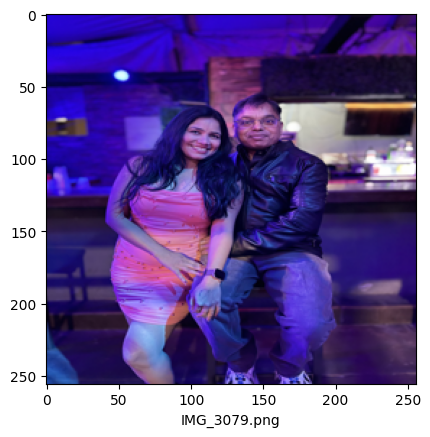

In [100]:

img_loc = os.path.join(os.getcwd(), "Photos-001")

all_images = os.listdir(img_loc)

one_image_file_name = all_images[0]
one_image = os.path.join(img_loc, one_image_file_name)
image = Image.open(one_image).convert("RGB")
image = image.resize((256, 256))

plt.figure()
show_image = mpimg.imread(one_image)
plt.xlabel(one_image_file_name)
plt.imshow(show_image)

output = compute_similar_images(image,0.1, embedding, device)
similar_list = []
output = output[0]
for i in output:
    similar_list.append(all_images[i])

# similar_list.remove(one_image_file_name)

print(similar_list)




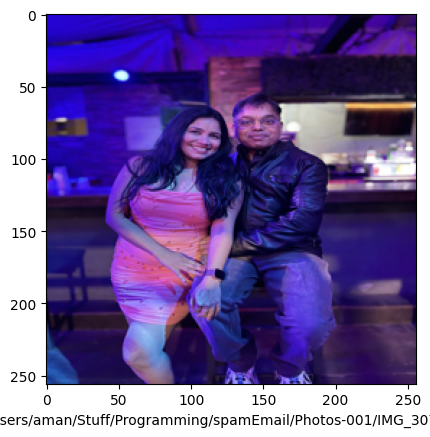

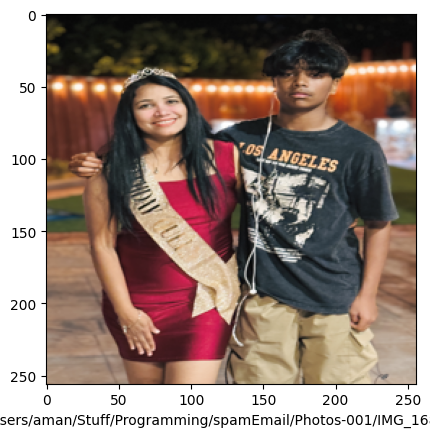

In [101]:
# IPython.display()
import matplotlib.image as mpimg

def process(filename, file):
    image = mpimg.imread(file)
    plt.figure()
    plt.xlabel(filename)
    plt.imshow(image)

file_name = []
for i in similar_list:
    image_path = os.path.join(os.getcwd(), "Photos-001", i)
    one_image = os.path.join(img_loc, i)
    process(one_image, image_path)
